# nnU-Net AMOS22 — Ensemble Inference + Jupyter Visualization Cockpit

Generated: 2026-02-08T15:25:00

This notebook is a **cockpit** for:
- running **ensemble inference** (folds 0–4) using your frozen baseline
- visualizing overlays (CT + labelmap)
- exporting quick QC montages

> Long training remains CLI/headless. This notebook is for inference + qualitative QA.


## 0) Configure paths

Edit the paths below once, then reuse.

In [1]:

from pathlib import Path

# --- REQUIRED: set these for your machine ---
REPO_ROOT = Path(r"C:\Users\hyeon\Documents\miniconda_medimg_env\abdomen-multiorgan-segmentation")

# Input folder: contains one or more cases named like `case_001_0000.nii.gz`
IN_DIR = REPO_ROOT / "inference" / "inputs" / "my_ct_cases"

# Output folder: nnU-Net predictions (labelmaps) will be written here
OUT_DIR = REPO_ROOT / "inference" / "outputs" / "my_ct_cases_pred"

# nnU-Net dataset configuration (frozen baseline)
DATASET_ID = 701
CONFIG = "3d_fullres"
FOLDS = [0, 1, 2, 3, 4]  # ensemble folds

# --- AMOS22 labels (CT) ---
LABELS = {
 0: "background",
 1: "spleen",
 2: "right kidney",
 3: "left kidney",
 4: "gall bladder",
 5: "esophagus",
 6: "liver",
 7: "stomach",
 8: "aorta",
 9: "IVC",
 10: "pancreas",
 11: "right adrenal gland",
 12: "left adrenal gland",
 13: "duodenum",
 14: "bladder",
 15: "prostate/uterus",
}

IN_DIR, OUT_DIR


(WindowsPath('C:/Users/hyeon/Documents/miniconda_medimg_env/abdomen-multiorgan-segmentation/inference/inputs/my_ct_cases'),
 WindowsPath('C:/Users/hyeon/Documents/miniconda_medimg_env/abdomen-multiorgan-segmentation/inference/outputs/my_ct_cases_pred'))

## 1) Confirm nnU-Net environment variables

Run your `set_nnunet_paths.bat` in the same terminal you used to launch Jupyter. This cell lets you verify from inside the notebook.

In [2]:

import os

for k in ["nnUNet_raw", "nnUNet_preprocessed", "nnUNet_results"]:
    print(f"{k}: {os.environ.get(k)}")


nnUNet_raw: C:\Users\hyeon\Documents\miniconda_medimg_env\data\nnunet_amos22\nnunet_raw
nnUNet_preprocessed: C:\Users\hyeon\Documents\miniconda_medimg_env\data\nnunet_amos22\nnunet_preprocessed
nnUNet_results: C:\Users\hyeon\Documents\miniconda_medimg_env\data\nnunet_amos22\nnunet_results


## 2) Run ensemble inference (folds 0–4)

This uses `nnUNetv2_predict` and produces one labelmap per case.

⚠️ Requires nnU-Net paths to be set (cell above).

In [3]:

# If needed, create output folder
OUT_DIR.mkdir(parents=True, exist_ok=True)

in_path = str(IN_DIR)
out_path = str(OUT_DIR)
fold_args = " ".join(str(f) for f in FOLDS)

cmd = f'nnUNetv2_predict -i "{in_path}" -o "{out_path}" -d {DATASET_ID} -c {CONFIG} -f {fold_args}'
print(cmd)

# Uncomment to run:
!{cmd}


nnUNetv2_predict -i "C:\Users\hyeon\Documents\miniconda_medimg_env\abdomen-multiorgan-segmentation\inference\inputs\my_ct_cases" -o "C:\Users\hyeon\Documents\miniconda_medimg_env\abdomen-multiorgan-segmentation\inference\outputs\my_ct_cases_pred" -d 701 -c 3d_fullres -f 0 1 2 3 4

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 2 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 2 cases that I would like to predict

Predicting AMOS22_amos_0023:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with AMOS22_am


100%|##########| 216/216 [00:32<00:00,  6.67it/s]

100%|##########| 216/216 [00:31<00:00,  6.84it/s]

100%|##########| 216/216 [00:31<00:00,  6.83it/s]

100%|##########| 216/216 [00:31<00:00,  6.83it/s]

100%|##########| 216/216 [00:31<00:00,  6.83it/s]

100%|##########| 225/225 [00:32<00:00,  6.85it/s]

100%|##########| 225/225 [00:32<00:00,  6.85it/s]

100%|##########| 225/225 [00:32<00:00,  6.85it/s]

100%|##########| 225/225 [00:32<00:00,  6.85it/s]

100%|##########| 225/225 [00:32<00:00,  6.85it/s]


## 3) Load a case and its prediction

Expected files:
- input image: `CASEID_0000.nii.gz` in `IN_DIR`
- prediction: `CASEID.nii.gz` in `OUT_DIR`

## Optional helper — copy a random preprocessed nnU-Net case for quick visualization

This cell copies **one random preprocessed case** from your nnU-Net dataset into the `my_ct_cases` folder so you can immediately test inference and visualization.

Use this ONLY for rapid QC. You can still use your own CT data later without changing anything.


In [5]:

import numpy as np
import nibabel as nib

def load_nifti(path):
    img = nib.load(str(path))
    data = img.get_fdata(dtype=np.float32)
    return img, data

def find_case_ids(in_dir: Path):
    ids = []
    for p in sorted(in_dir.glob("*_0000.nii.gz")):
        ids.append(p.name.replace("_0000.nii.gz",""))
    return ids

case_ids = find_case_ids(IN_DIR)
print("Found cases:", len(case_ids))
case_ids[:10]


Found cases: 2


['AMOS22_amos_0023', 'AMOS22_amos_0237']

In [9]:
import numpy as np
import nibabel as nib

def load_nifti(path):
    img = nib.load(str(path))
    data = img.get_fdata(dtype=np.float32)
    return img, data

def find_pred_file(out_dir: Path, case_id: str):
    # common candidate names
    candidates = [
        out_dir / f"{case_id}.nii.gz",
        out_dir / f"{case_id}.nii",
        out_dir / f"{case_id}_seg.nii.gz",
        out_dir / f"{case_id}_seg.nii",
    ]
    for c in candidates:
        if c.exists():
            return c

    # fallback: any file starting with case_id
    globs = sorted(out_dir.glob(f"{case_id}*.nii*"))
    return globs[0] if globs else None

CASE_ID = case_ids[0] if case_ids else None
print("CASE_ID:", CASE_ID)

if CASE_ID:
    img_path = IN_DIR / f"{CASE_ID}_0000.nii.gz"
    pred_path = find_pred_file(OUT_DIR, CASE_ID)

    print("Image:", img_path.exists(), img_path)

    if pred_path is None:
        print("\n❌ Prediction not found.")
        print("Expected something like:", OUT_DIR / f"{CASE_ID}.nii.gz")
        print("\nAction:")
        print("1) Run the ensemble inference cell (!nnUNetv2_predict ...).")
        print("2) Re-run the OUT_DIR listing diagnostic cell to confirm output exists.")
    else:
        print("Pred :", pred_path.exists(), pred_path)

        img_nii, img = load_nifti(img_path)
        pred_nii, pred = load_nifti(pred_path)
        pred = pred.astype(np.int16)

        print("Image shape:", img.shape, "dtype", img.dtype)
        print("Pred  shape:", pred.shape, "dtype", pred.dtype, "unique labels (sample):", np.unique(pred)[:30])


CASE_ID: AMOS22_amos_0023
Image: True C:\Users\hyeon\Documents\miniconda_medimg_env\abdomen-multiorgan-segmentation\inference\inputs\my_ct_cases\AMOS22_amos_0023_0000.nii.gz
Pred : True C:\Users\hyeon\Documents\miniconda_medimg_env\abdomen-multiorgan-segmentation\inference\outputs\my_ct_cases_pred\AMOS22_amos_0023.nii.gz
Image shape: (512, 512, 86) dtype float32
Pred  shape: (512, 512, 86) dtype int16 unique labels (sample): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [10]:
from pathlib import Path

print("IN_DIR :", IN_DIR)
print("OUT_DIR:", OUT_DIR)

print("\nIN_DIR files (up to 10):")
for p in sorted(IN_DIR.glob("*.nii*"))[:10]:
    print(" -", p.name)

print("\nOUT_DIR files (up to 10):")
for p in sorted(OUT_DIR.glob("*.nii*"))[:10]:
    print(" -", p.name)

# Helpful: show whether OUT_DIR exists and how many predictions are present
print("\nOUT_DIR exists:", OUT_DIR.exists())
print("Prediction candidates in OUT_DIR:", len(list(OUT_DIR.glob("*.nii.gz"))))


IN_DIR : C:\Users\hyeon\Documents\miniconda_medimg_env\abdomen-multiorgan-segmentation\inference\inputs\my_ct_cases
OUT_DIR: C:\Users\hyeon\Documents\miniconda_medimg_env\abdomen-multiorgan-segmentation\inference\outputs\my_ct_cases_pred

IN_DIR files (up to 10):
 - AMOS22_amos_0023_0000.nii.gz
 - AMOS22_amos_0237_0000.nii.gz

OUT_DIR files (up to 10):
 - AMOS22_amos_0023.nii.gz
 - AMOS22_amos_0237.nii.gz

OUT_DIR exists: True
Prediction candidates in OUT_DIR: 2


In [18]:
import nibabel as nib
import numpy as np

def load_nifti(path):
    nii = nib.load(str(path))

    # Force canonical orientation (RAS)
    nii = nib.as_closest_canonical(nii)

    data = nii.get_fdata(dtype=np.float32)
    return nii, data


In [29]:
from nibabel.orientations import aff2axcodes

img_codes = aff2axcodes(img_nii.affine)
pred_codes = aff2axcodes(pred_nii.affine)

print("Image orientation:", img_codes)
print("Pred orientation :", pred_codes)


Image orientation: ('R', 'A', 'S')
Pred orientation : ('R', 'A', 'S')


In [19]:

# Pick a case to inspect
CASE_ID = case_ids[0] if case_ids else None
print("CASE_ID:", CASE_ID)

if CASE_ID:
    img_path = IN_DIR / f"{CASE_ID}_0000.nii.gz"
    pred_path = OUT_DIR / f"{CASE_ID}.nii.gz"

    print("Image:", img_path.exists(), img_path)
    print("Pred :", pred_path.exists(), pred_path)
    
    img_nii, img = load_nifti(img_path)
    pred_nii, pred = load_nifti(pred_path)
    pred = pred.astype(np.int16)

    print("Image shape:", img.shape, "dtype:", img.dtype)
    print("Pred  shape:", pred.shape, "dtype:", pred.dtype)
    print("Unique labels (sample):", np.unique(pred)[:30])


CASE_ID: AMOS22_amos_0023
Image: True C:\Users\hyeon\Documents\miniconda_medimg_env\abdomen-multiorgan-segmentation\inference\inputs\my_ct_cases\AMOS22_amos_0023_0000.nii.gz
Pred : True C:\Users\hyeon\Documents\miniconda_medimg_env\abdomen-multiorgan-segmentation\inference\outputs\my_ct_cases_pred\AMOS22_amos_0023.nii.gz
Image shape: (512, 512, 86) dtype: float32
Pred  shape: (512, 512, 86) dtype: int16
Unique labels (sample): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


## 4) Visualization helpers (overlay + montage)

These functions generate quick qualitative QC overlays.

In [81]:

import matplotlib.pyplot as plt
spacing = np.sqrt((img_nii.affine[:3, :3] ** 2).sum(0))
# ct2d = img[z, :, :]
# seg2d = pred[z, :, :]

def window_ct(x, wl=40, ww=400):  # abdomen default
    lo = wl - ww/2
    hi = wl + ww/2
    x = np.clip(x, lo, hi)
    return (x - lo) / (hi - lo)

def overlay_slice(ct2d, seg2d, label_ids, alpha=0.35):    
    ct = window_ct(ct2d)
    mask = np.isin(seg2d, label_ids).astype(np.float32)
    return ct, mask

def montage_overlays(img3d, seg3d, label_ids, z_slices, ncols=5, suptitle=None):
    n = len(z_slices)
    nrows = int(np.ceil(n / ncols))
    fig = plt.figure(figsize=(3*ncols, 3*nrows))
    for i, z in enumerate(z_slices):
        ax = fig.add_subplot(nrows, ncols, i+1)
        
        ct, mask = overlay_slice(img3d[:, z, :], seg3d[:, z, :], label_ids)
        
        ct = np.rot90(ct,k=1)
        mask = np.rot90(mask, k=1)
        
        ax.imshow(ct, cmap="gray", aspect=spacing[2]/spacing[1])
        ax.imshow(mask, alpha=0.35, aspect=spacing[2]/spacing[1])  # default cmap for QC
        ax.set_title(f"z={z}")
        ax.axis("off")
    if suptitle:
        fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

    plt.savefig('my_image_plot.png', dpi=300) 



## 5) Organ-focused QC montage

Pick one organ label, find slices where it appears, and render a montage.

Slices with label: 249
First/last: (173, 421)


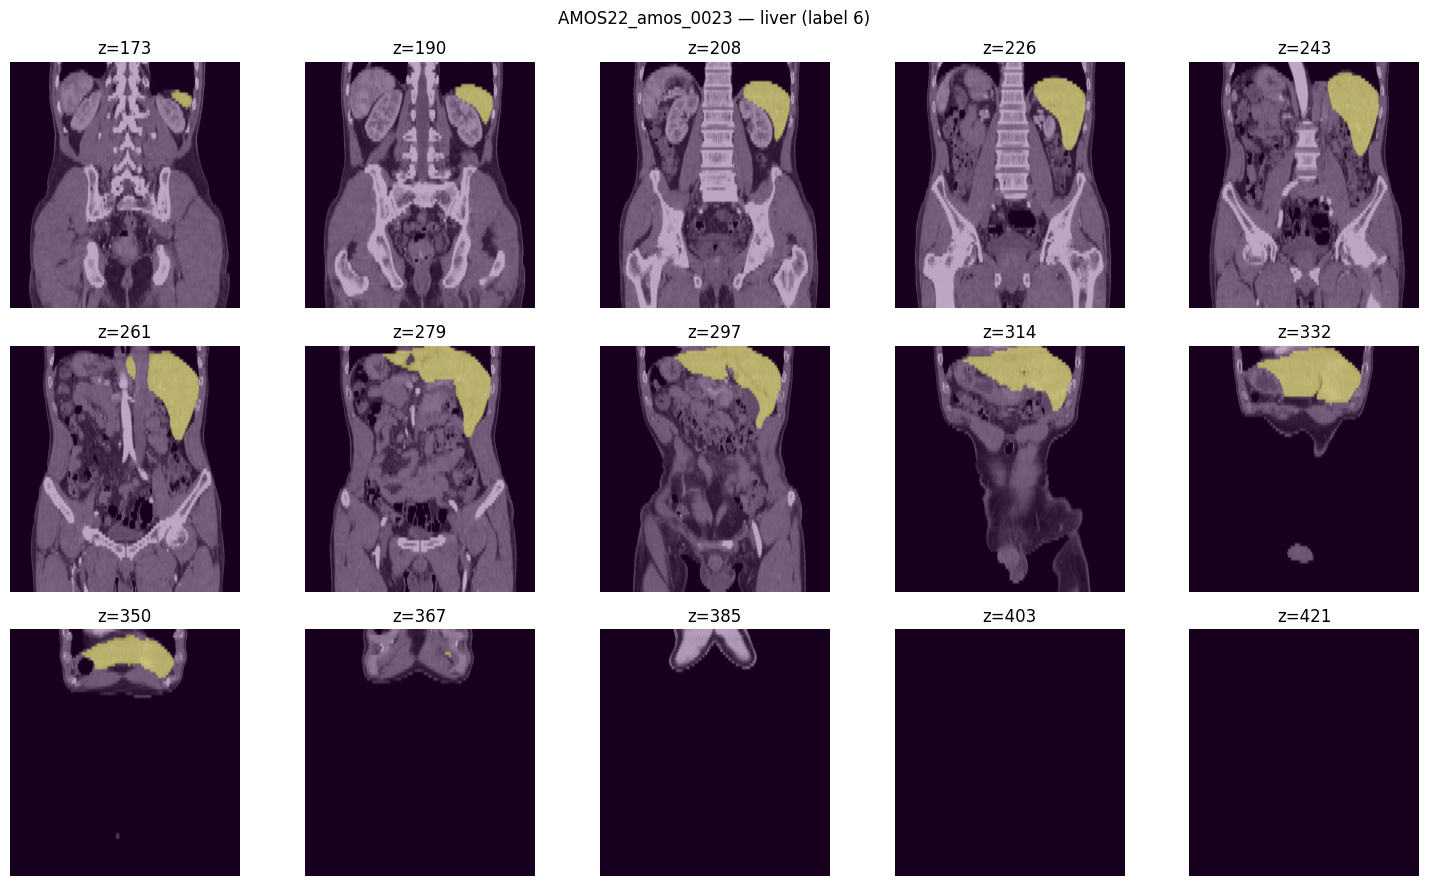

<Figure size 640x480 with 0 Axes>

In [82]:

def slices_with_label(seg3d, label_id, min_pixels=200):
    zs = []
    for z in range(seg3d.shape[0]):
        if np.sum(seg3d[z, :, :] == label_id) >= min_pixels:
            zs.append(z)
    return zs

LABEL_ID = 6  # liver (example)
name = LABELS.get(LABEL_ID, f"label_{LABEL_ID}")

zs = slices_with_label(pred, LABEL_ID, min_pixels=200)
print("Slices with label:", len(zs))
print("First/last:", (zs[0], zs[-1]) if zs else None)

if zs:
    k = min(15, len(zs))
    idx = np.linspace(0, len(zs)-1, k).astype(int)
    z_samp = [zs[i] for i in idx]
    montage_overlays(img, pred, [LABEL_ID], z_samp, ncols=5, suptitle=f"{CASE_ID} — {name} (label {LABEL_ID})")


## 6) Whole-foreground QC montage

Overlays all non-zero labels (useful for catching gross misalignment).

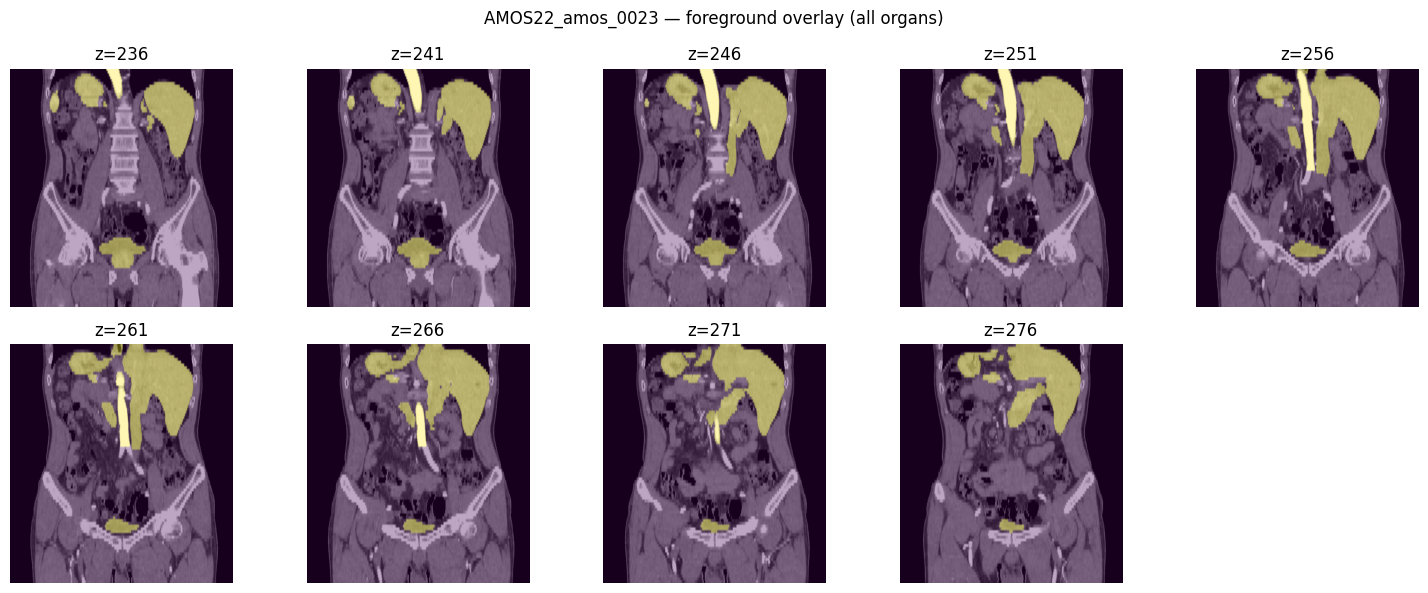

<Figure size 640x480 with 0 Axes>

In [83]:

foreground_ids = [i for i in sorted(LABELS.keys()) if i != 0]
z_center = img.shape[0] // 2
z_samp = list(range(max(0, z_center-20), min(img.shape[0], z_center+25), 5))
montage_overlays(img, pred, foreground_ids, z_samp, ncols=5, suptitle=f"{CASE_ID} — foreground overlay (all organs)")


## 7) Export a montage to PNG (optional)

Exports into `baseline_nnunet/reports/qc_exports/` for easy GitHub inclusion.

In [70]:

EXPORT_DIR = REPO_ROOT / "baseline_nnunet" / "reports" / "qc_exports"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

def save_montage(img3d, seg3d, label_ids, z_slices, out_png: Path, ncols=5, title=None):
    n = len(z_slices)
    nrows = int(np.ceil(n / ncols))
    fig = plt.figure(figsize=(3*ncols, 3*nrows))
    for i, z in enumerate(z_slices):
        ax = fig.add_subplot(nrows, ncols, i+1)
        ct, mask = overlay_slice(img3d[z, :, :], seg3d[z, :, :], label_ids)
        ax.imshow(ct, cmap="gray")
        ax.imshow(mask, alpha=0.35)
        ax.set_title(f"z={z}")
        ax.axis("off")
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    fig.savefig(str(out_png), dpi=200, bbox_inches="tight")
    plt.close(fig)
    return out_png

LABEL_ID = 6
name = LABELS.get(LABEL_ID, f"label_{LABEL_ID}")
zs = slices_with_label(pred, LABEL_ID, min_pixels=200)

if zs:
    k = min(15, len(zs))
    idx = np.linspace(0, len(zs)-1, k).astype(int)
    z_samp = [zs[i] for i in idx]
    out_png = EXPORT_DIR / f"{CASE_ID}_label{LABEL_ID}_{name.replace(' ','_')}.png"
    saved = save_montage(img, pred, [LABEL_ID], z_samp, out_png, title=f"{CASE_ID} — {name}")
    print("Saved:", saved)
else:
    print("No slices found for label", LABEL_ID)


Saved: C:\Users\hyeon\Documents\miniconda_medimg_env\abdomen-multiorgan-segmentation\baseline_nnunet\reports\qc_exports\AMOS22_amos_0023_label6_liver.png


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Safety checks
assert "img" in globals() and "pred" in globals(), "Run the load case cell first (img, pred)."
assert img.shape == pred.shape, f"Shape mismatch: img {img.shape} vs pred {pred.shape}"

# Build label options
label_options = [("All foreground", -1)]
label_options += [(f"{k:02d} — {v}", k) for k, v in LABELS.items() if k != 0]  # exclude background


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

assert "img" in globals() and "pred" in globals()
assert img.shape == pred.shape

# spacing from affine (mm)
spacing = np.sqrt((img_nii.affine[:3, :3] ** 2).sum(0))  # (sx, sy, sz)

def window_ct(x, wl=40, ww=400):
    lo = wl - ww/2
    hi = wl + ww/2
    x = np.clip(x, lo, hi)
    return (x - lo) / (hi - lo)

def get_slice(vol, idx, plane):
    # assume vol is in canonical orientation (X,Y,Z) after nib.as_closest_canonical
    if plane == "axial":     # slice along Z -> show X-Y
        return vol[:, :, idx], (spacing[1], spacing[0])  # (row_spacing, col_spacing) for imshow
    if plane == "coronal":   # slice along Y -> show X-Z
        return vol[:, idx, :], (spacing[2], spacing[0])
    if plane == "sagittal":  # slice along X -> show Y-Z
        return vol[idx, :, :], (spacing[2], spacing[1])
    raise ValueError("plane must be axial/coronal/sagittal")

# widgets
plane_dd = widgets.Dropdown(options=["axial", "coronal", "sagittal"], value="axial", description="Plane")
z_slider = widgets.IntSlider(value=img.shape[2]//2, min=0, max=img.shape[2]-1, step=1, description="Index")

label_options = [("All foreground", -1)] + [(f"{k:02d} — {v}", k) for k, v in LABELS.items() if k != 0]
label_dd = widgets.Dropdown(options=label_options, value=-1, description="Label")

alpha_slider = widgets.FloatSlider(value=0.35, min=0.0, max=1.0, step=0.05, description="Alpha")
wl_slider = widgets.IntSlider(value=40, min=-200, max=200, step=5, description="WL")
ww_slider = widgets.IntSlider(value=400, min=50, max=2000, step=50, description="WW")

rot_chk = widgets.Checkbox(value=True, description="Rotate 90° left")
flip_lr_chk = widgets.Checkbox(value=False, description="Flip LR (display)")

contour_chk = widgets.Checkbox(value=True, description="Contour")
fill_chk = widgets.Checkbox(value=False, description="Fill mask")

ui1 = widgets.HBox([plane_dd, z_slider, label_dd])
ui2 = widgets.HBox([alpha_slider, wl_slider, ww_slider])
ui3 = widgets.HBox([rot_chk, flip_lr_chk, contour_chk, fill_chk])
out = widgets.Output()

def update_slider_for_plane(*args):
    plane = plane_dd.value
    # choose the axis index range based on plane
    if plane == "axial":
        z_slider.max = img.shape[2] - 1
        z_slider.value = min(z_slider.value, z_slider.max)
    elif plane == "coronal":
        z_slider.max = img.shape[1] - 1
        z_slider.value = min(z_slider.value, z_slider.max)
    elif plane == "sagittal":
        z_slider.max = img.shape[0] - 1
        z_slider.value = min(z_slider.value, z_slider.max)

plane_dd.observe(update_slider_for_plane, names="value")
update_slider_for_plane()

def render(plane, idx, label_id, alpha, wl, ww, rot90_left, flip_lr, contour, fill_mask):
    with out:
        clear_output(wait=True)

        ct2d, (row_sp, col_sp) = get_slice(img, idx, plane)
        seg2d, _ = get_slice(pred.astype(np.int16), idx, plane)

        ct2d = window_ct(ct2d, wl=wl, ww=ww)

        # optional rotate to match your preference
        if rot90_left:
            ct2d = np.rot90(ct2d, k=1)
            seg2d = np.rot90(seg2d, k=1)
            # rotation swaps row/col spacing
            row_sp, col_sp = col_sp, row_sp

        if flip_lr:
            ct2d = np.fliplr(ct2d)
            seg2d = np.fliplr(seg2d)

        aspect = row_sp / col_sp

        plt.figure(figsize=(7, 7))
        plt.imshow(ct2d, cmap="gray", aspect=aspect)
        plt.axis("off")

        if label_id == -1:
            mask = (seg2d != 0)
            title = f"{CASE_ID} — {plane} idx={idx} — All foreground"
        else:
            mask = (seg2d == int(label_id))
            title = f"{CASE_ID} — {plane} idx={idx} — {LABELS.get(int(label_id), label_id)} (id={label_id})"

        if fill_mask:
            plt.imshow(mask.astype(np.float32), alpha=alpha)

        if contour:
            plt.contour(mask.astype(np.float32), levels=[0.5], linewidths=1.0)

        plt.title(title)
        plt.show()

widgets.interactive_output(
    render,
    {
        "plane": plane_dd,
        "idx": z_slider,
        "label_id": label_dd,
        "alpha": alpha_slider,
        "wl": wl_slider,
        "ww": ww_slider,
        "rot90_left": rot_chk,
        "flip_lr": flip_lr_chk,
        "contour": contour_chk,
        "fill_mask": fill_chk,
    },
)

display(ui1, ui2, ui3, out)
render(plane_dd.value, z_slider.value, label_dd.value, alpha_slider.value, wl_slider.value, ww_slider.value,
       rot_chk.value, flip_lr_chk.value, contour_chk.value, fill_chk.value)


Output()